In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm #color module
from matplotlib.dates import date2num, DateFormatter
# from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout() # eliminate the white space btw plots
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/home/qiyue_ren/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///data/data.db'
events_db = 'crypto_events_database'

In [3]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "BTC"
connection_string = "sqlite:///data/data.db"
events_db = "crypto_events_database"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)

prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)
prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,50274.37,50828.13,50274.37,50489.97,1629.235048,8.234571e+07,BTC,BTC
2021-12-12 20:00:00,50481.75,50621.33,50148.04,50240.20,424.455328,2.138626e+07,BTC,BTC
2021-12-12 21:00:00,50245.59,50589.46,50180.32,50305.85,410.233785,2.068859e+07,BTC,BTC


## question1:

### calculate the hourly return by timestamp

In [5]:
def returns_ohlc(df, lookback=3):
    '''
    calculate the returns
    '''

    c = prices.close
    result = c/c.shift(1) - 1
    
    return result

In [6]:
prices['returns'] = returns_ohlc(prices)
prices

,open,high,low,close,volume,volumeUSD,token,chain,returns
ts,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008588
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002056
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005731
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853
...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,50274.37,50828.13,50274.37,50489.97,1629.235048,8.234571e+07,BTC,BTC,0.004102
2021-12-12 20:00:00,50481.75,50621.33,50148.04,50240.20,424.455328,2.138626e+07,BTC,BTC,-0.004947
2021-12-12 21:00:00,50245.59,50589.46,50180.32,50305.85,410.233785,2.068859e+07,BTC,BTC,0.001307


### calculate the hourly volatility by timestamp

In [7]:
def vol_ohlc(df, lookback=3):
    '''
    calculate the volatility
    '''
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [8]:
prices['vol'] = vol_ohlc(prices)
prices

,open,high,low,close,volume,volumeUSD,token,chain,returns,vol
ts,,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN,NaN
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008588,NaN
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002056,NaN
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005731,0.143031
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853,0.114044
...,...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,50274.37,50828.13,50274.37,50489.97,1629.235048,8.234571e+07,BTC,BTC,0.004102,0.139230
2021-12-12 20:00:00,50481.75,50621.33,50148.04,50240.20,424.455328,2.138626e+07,BTC,BTC,-0.004947,0.144468
2021-12-12 21:00:00,50245.59,50589.46,50180.32,50305.85,410.233785,2.068859e+07,BTC,BTC,0.001307,0.131469


### calulate maximum drawdown up to that hour for each hour

In [9]:
def max_drawdown_ohlc(df):
    '''
    calulate maximum drawdown
    '''
    l = df.low
    h = df.high
    
    drawdown = (l-h)/h
    result = pd.Series(index = df.index)
    for i in df.index:
        result[i] = drawdown[:i].max()
    
    return result

In [10]:
prices['max_drawdown'] = max_drawdown_ohlc(prices)
prices

/tmp/ipykernel_4185/2152035505.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = pd.Series(index = df.index)


,open,high,low,close,volume,volumeUSD,token,chain,returns,vol,max_drawdown
ts,,,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN,NaN,-0.024604
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008588,NaN,-0.014150
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002056,NaN,-0.012188
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005731,0.143031,-0.007386
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853,0.114044,-0.003981
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,50274.37,50828.13,50274.37,50489.97,1629.235048,8.234571e+07,BTC,BTC,0.004102,0.139230,-0.003132
2021-12-12 20:00:00,50481.75,50621.33,50148.04,50240.20,424.455328,2.138626e+07,BTC,BTC,-0.004947,0.144468,-0.003132
2021-12-12 21:00:00,50245.59,50589.46,50180.32,50305.85,410.233785,2.068859e+07,BTC,BTC,0.001307,0.131469,-0.003132


### ploting

In [11]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))  # 产生从start到stop的等差数列, 数列个数为num
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1) 
        # Create lines or rectangles that span the axes, alpha stands for transparency 

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1 
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':') # Draw a vline at x that spans the yrange, (1-0.2)100% shown
                ax.text(x, ymin, row.event, rotation=90, color='0.2')  # including text in a figure
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')
                


In [12]:
%%capture 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

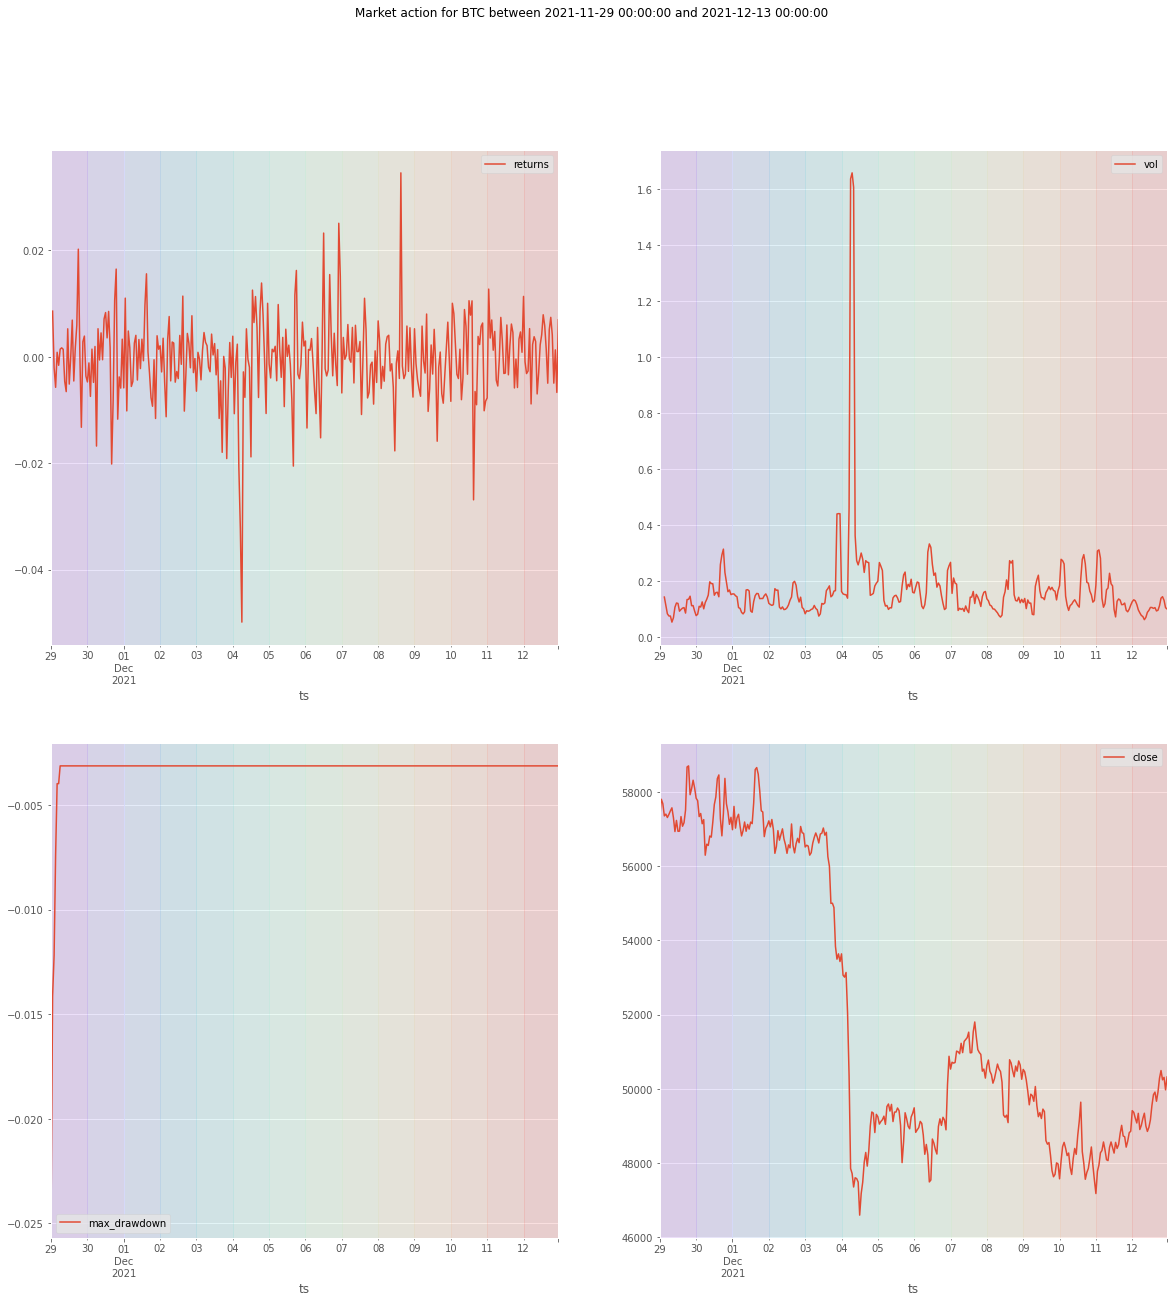

In [13]:
series_plot(prices[['returns']], ax=ax[0, 0])
series_plot(prices[['vol']], ax=ax[0, 1])
series_plot(prices[['max_drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

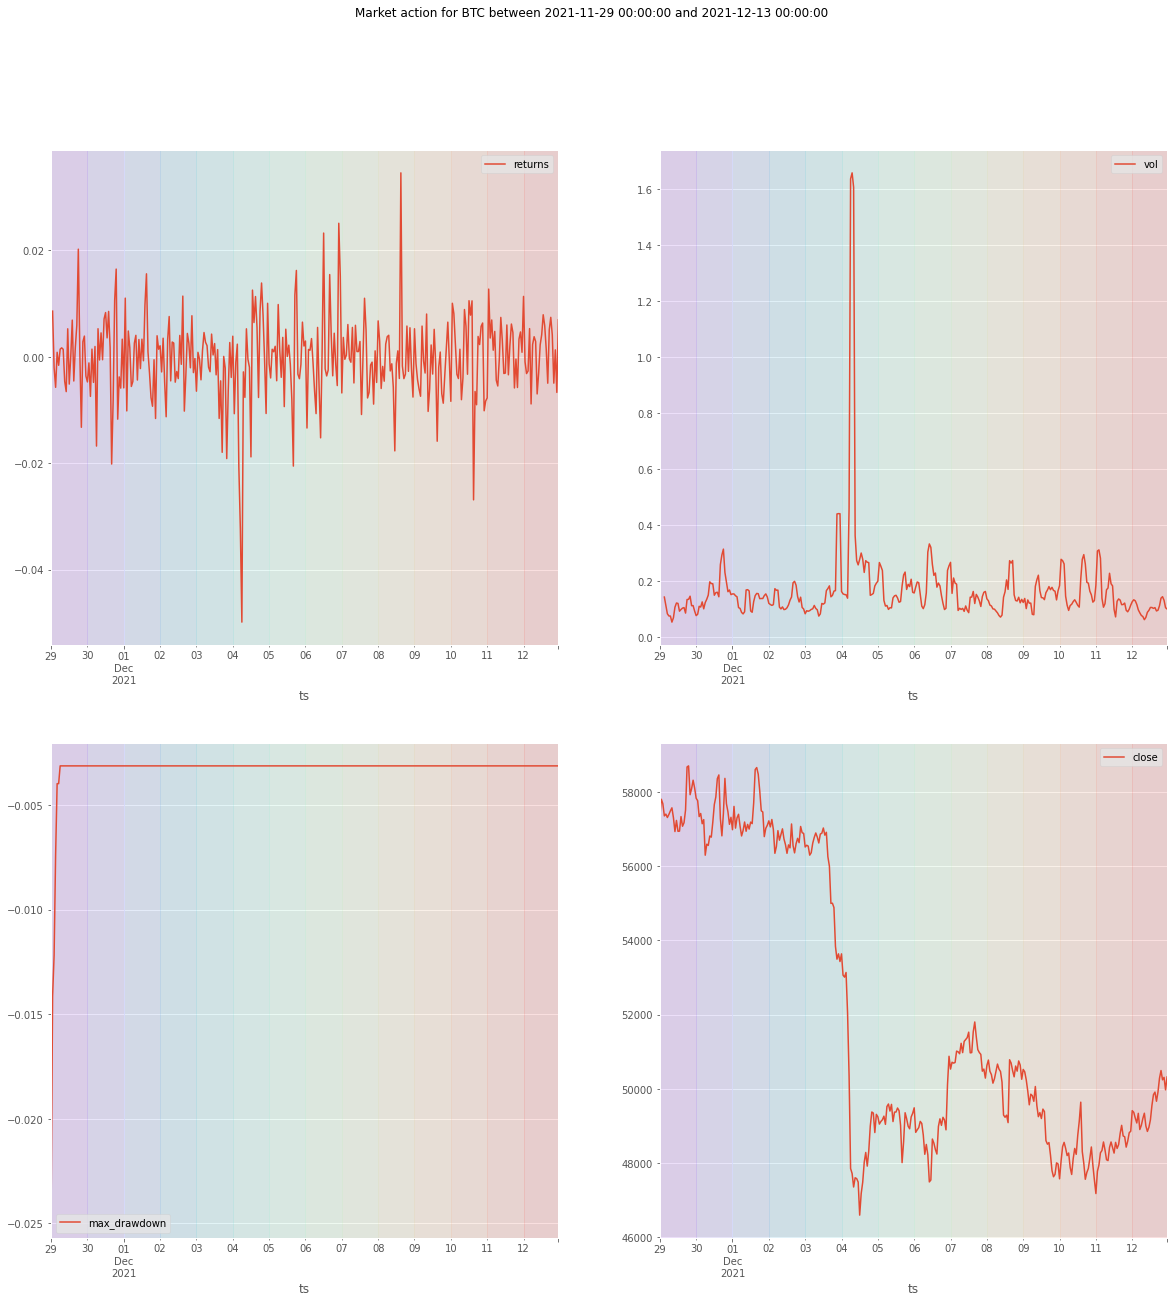

In [14]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)